# **Análise de dados da bolsa de valores (Ibovespa) dos últimos 10 anos**

O nosso desafio era imaginar que fomos contratados para um time de investimentos e precisaríamos realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilizamos a base de dados contida no site da investing com total liberdade de escolha do período para análise.

Precisamos mostrar para o time de investimentos:

*   O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
*   Justificar a técnica utilizada;
*   Atingir uma acuracidade adequada (acima de 70%).


# **Importando as bibliotecas**

Vamos começar a nossa análise importando as principais bibliotecas que vamos utilizar na nossa análise, tais como: pandas, numpy, matplotlib, seaborn, etc.
As demais bibliotecas serão utilizadas conforme as necessidades dos testes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sb
from statsmodels.tsa.seasonal import seasonal_decompose

# **Importando o dataset para o notebook**

Agora vamos realizar a importação da nossa base de dados que está em csv para o colab e começar a conhecer os dados.

In [ ]:
df = pd.read_csv("/content/Dados Históricos - Ibovespa.csv", sep = ",")

# **Conhecendo o dataset**

Fizemos a escolha dos nossos dados por meio do site da [investing](https://br.investing.com/indices/bovespa-historical-data) segmentando para trazer os dados dos últimos 10 anos (01/01/2014 até 26/01/2024), selecionamos inicialmente esse período por resultar em uma quantidade de dados legais para o modelo e não pegar dados muito antigos que podem ser negativos para o resultado atual.

In [ ]:
# Com o head conseguimos verificar as colunas que temos no dataset e os dados mais atuais
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,26.01.2024,128.967,128.164,129.252,127.869,"8,51M","0,62%"
1,25.01.2024,128.169,127.815,128.697,127.803,"8,76M","0,28%"
2,24.01.2024,127.816,128.275,129.446,127.680,"8,82M","-0,35%"
3,23.01.2024,128.263,126.612,128.331,126.612,"9,37M","1,31%"
4,22.01.2024,126.602,127.636,127.843,126.118,"9,51M","-0,81%"


In [ ]:
# Com o tail podemos verificar que todos os nosos dados foram gerados corretamente, dado que a última linha é de 02/01/2014
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2490,08.01.2014,50.577,50.431,50.793,50.424,"2,92M","0,29%"
2491,07.01.2014,50.430,50.982,51.478,50.429,"3,34M","-1,07%"
2492,06.01.2014,50.974,50.980,51.002,50.451,"3,73M","-0,01%"
2493,03.01.2014,50.981,50.348,50.981,50.269,"7,36M","1,27%"
2494,02.01.2014,50.341,51.522,51.656,50.246,"3,48M","-2,26%"


In [ ]:
# Shape para saber a quantidade extas de linhas e colunas
df.shape

(2495, 7)

In [ ]:
#Com o df.info, conseguimos notar que a data está como object, assim como o Vol e a Var, o que é um problema que precisaremos solucionar.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2495 non-null   object 
 1   Último    2495 non-null   float64
 2   Abertura  2495 non-null   float64
 3   Máxima    2495 non-null   float64
 4   Mínima    2495 non-null   float64
 5   Vol.      2494 non-null   object 
 6   Var%      2495 non-null   object 
dtypes: float64(4), object(3)
memory usage: 136.6+ KB


In [ ]:
# Com o describe podemos notar que históricamente os dados não variam muito entre abertura, fechamento, valor máximo e valor mínimo.
df.describe().round()

,Último,Abertura,Máxima,Mínima
count,2495.0,2495.0,2495.0,2495.0
mean,85.0,85.0,86.0,84.0
std,27.0,27.0,27.0,26.0
min,37.0,38.0,38.0,37.0
25%,58.0,58.0,58.0,57.0
50%,86.0,86.0,87.0,85.0
75%,109.0,109.0,110.0,108.0
max,134.0,134.0,134.0,134.0


# **Manipulando os dados**

Aqui vamos realizar as primeiras validações para descobrir se temos dados em branco, dados repetidos e fazer algumas transformações nos dados caso sejam necessárias.

In [ ]:
# Identificamos uma linha em branco na coluna 'Vol-'
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [ ]:
# aqui podemos notar que é uma linha em 2016 e que todos os outros dados estão preenchidos corretamente.
# e como decidimos não seguir com essa coluna no treinamento do modelo não iremos tratar essa linha em branco.

linhas_com_nulos = df[df.isnull().any(axis=1)]
print(linhas_com_nulos)

            Data  Último  Abertura  Máxima  Mínima Vol.    Var%
1976  10.02.2016  40.377    40.592  40.592   39.96  NaN  -0,53%


In [ ]:
df = df.dropna()
df.isna().sum()

In [ ]:
#Não temos linhas duplicadas no nosso dataset
df.duplicated().sum()

0

In [ ]:
# Como podemos notar a coluna 'Data' está no dataset como object(texto), nesse caso precisamos formatá-la para datetime.
# Como notamos anteriormente que históricamente as demais colunas não variam muito, decidimos seguir inicialmente somente com o fechamento do mercado para treinar o modelo 'Último' e a 'Data'
# Sendo assim, não vamos modificar as outras colunas neste momento.
print(df.dtypes)

Data         object
Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.         object
Var%         object
dtype: object


In [ ]:
#Convertendo a 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')

In [ ]:
# Verificando alterações
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      2495 non-null   datetime64[ns]
 1   Último    2495 non-null   float64       
 2   Abertura  2495 non-null   float64       
 3   Máxima    2495 non-null   float64       
 4   Mínima    2495 non-null   float64       
 5   Vol.      2494 non-null   object        
 6   Var%      2495 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 136.6+ KB


# **Visualizando os dados**

Vamos entender melhor as informações que encontramos e tirar insghts com algumas visualizações do matplotlib

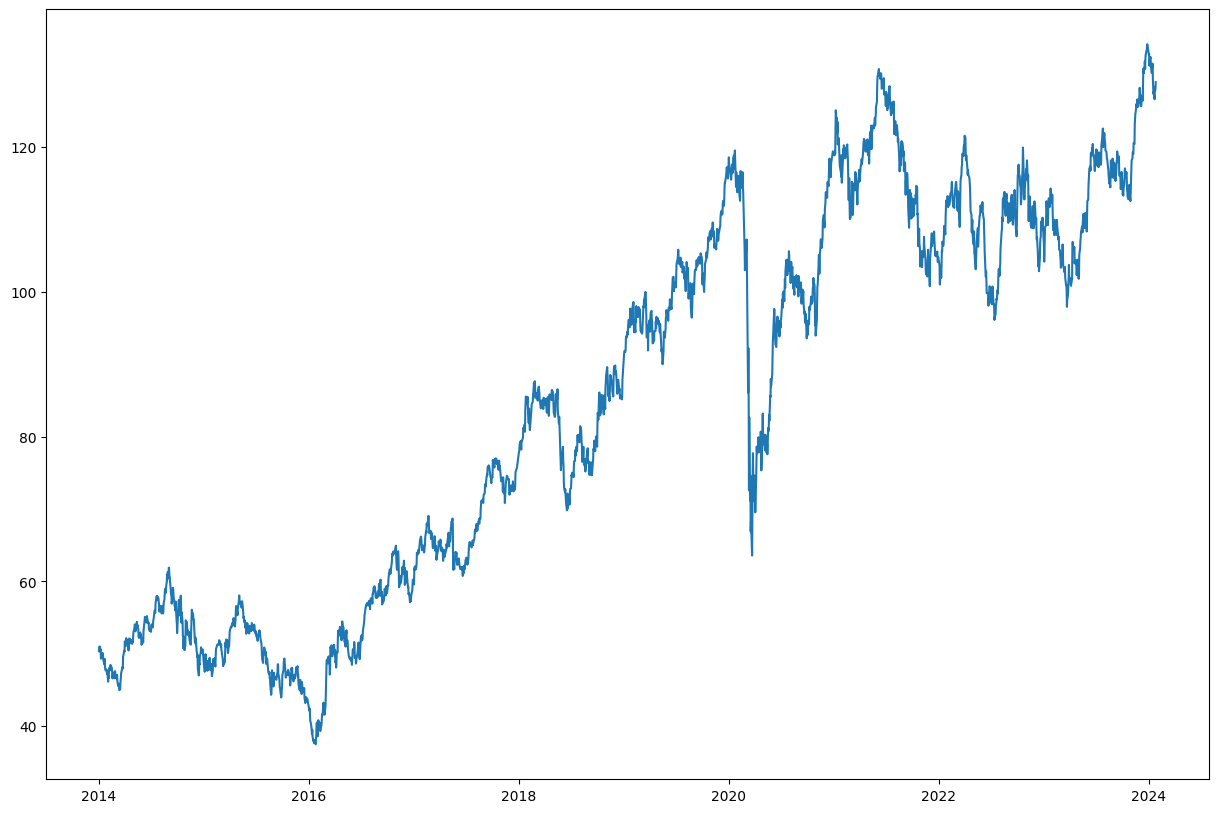

In [ ]:
# primeiro plot

plt.figure(figsize = (15,10))
plt.plot(df['Data'], df['Último'], label='IBOVESPA')

plt.show()

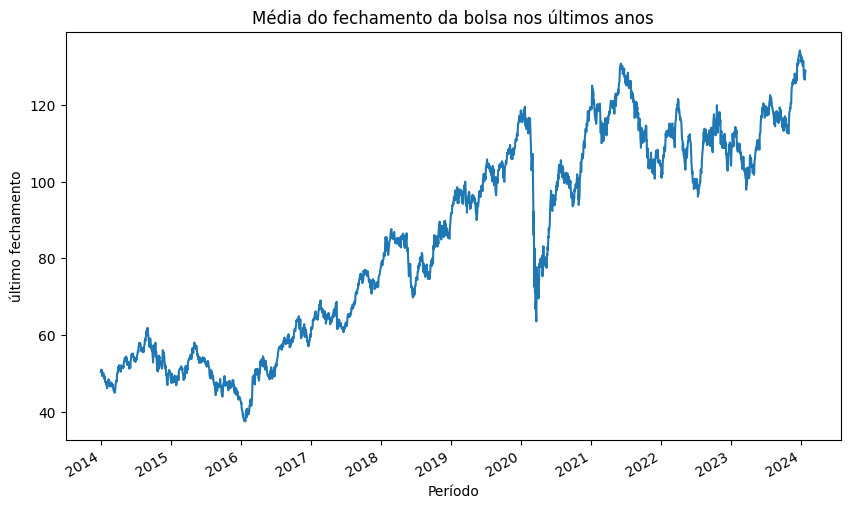

In [ ]:
# Melhorando o plot para poder analisar melhor, aqui de cara podemos notar que a série não é nada regular, isso já nos direciona um pouco qual modelo escolher no final.

plt.figure(figsize=(10, 6))
plt.plot(df['Data'], df['Último'])
plt.ylabel('último fechamento')
plt.xlabel('Período')
plt.title('Média do fechamento da bolsa nos últimos anos')

# Define um formato de data para mostrar apenas o ano
date_format = mdates.DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Mostra rótulos a cada ano
plt.gcf().autofmt_xdate()  # Ajusta a inclinação para melhorar a legibilidade

plt.show()

<ipython-input-727-4b7e150f1c73>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resampled = df.resample('M').mean()  # Resample para média mensal


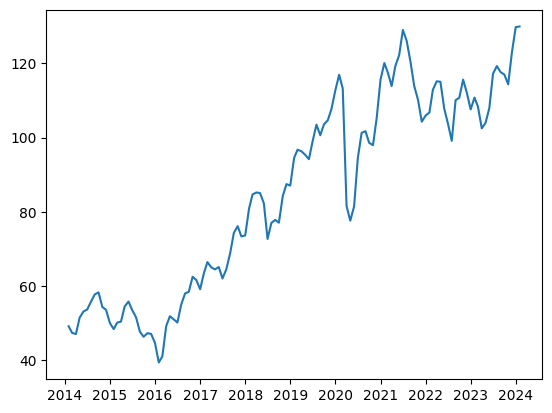

In [ ]:
# Modificando o index para facilitar a utilização do resample, aqui podemos notar que na média mensal também tem muita variação, o que signifca que não isso não se limita aos dias, mas sim a série como um todo.

df.set_index('Data', inplace=True)
df_resampled = df.resample('M').mean()  # Resample para média mensal
plt.plot(df_resampled.index, df_resampled['Último'])


<ipython-input-728-b5d8d3cac66d>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resampled_annual_10_years = df.resample('Y').mean()  # Resample para média anual


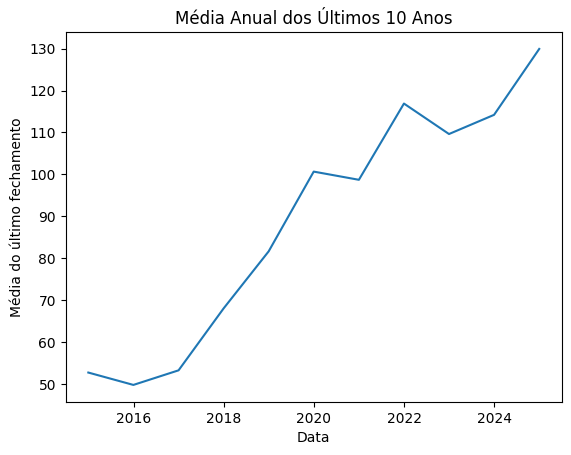

In [ ]:
# A média anual dos últimos anos vem crescendo, possivelmente essa será a nossa têndencia no resultado final do modelo.
df_resampled_annual_10_years = df.resample('Y').mean()  # Resample para média anual
plt.plot(df_resampled_annual_10_years.index, df_resampled_annual_10_years['Último'])
plt.title('Média Anual dos Últimos 10 Anos')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')
plt.show()

<ipython-input-729-6ce338e0b87e>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_2020_resampled_monthly = df_2020.resample('M').mean()


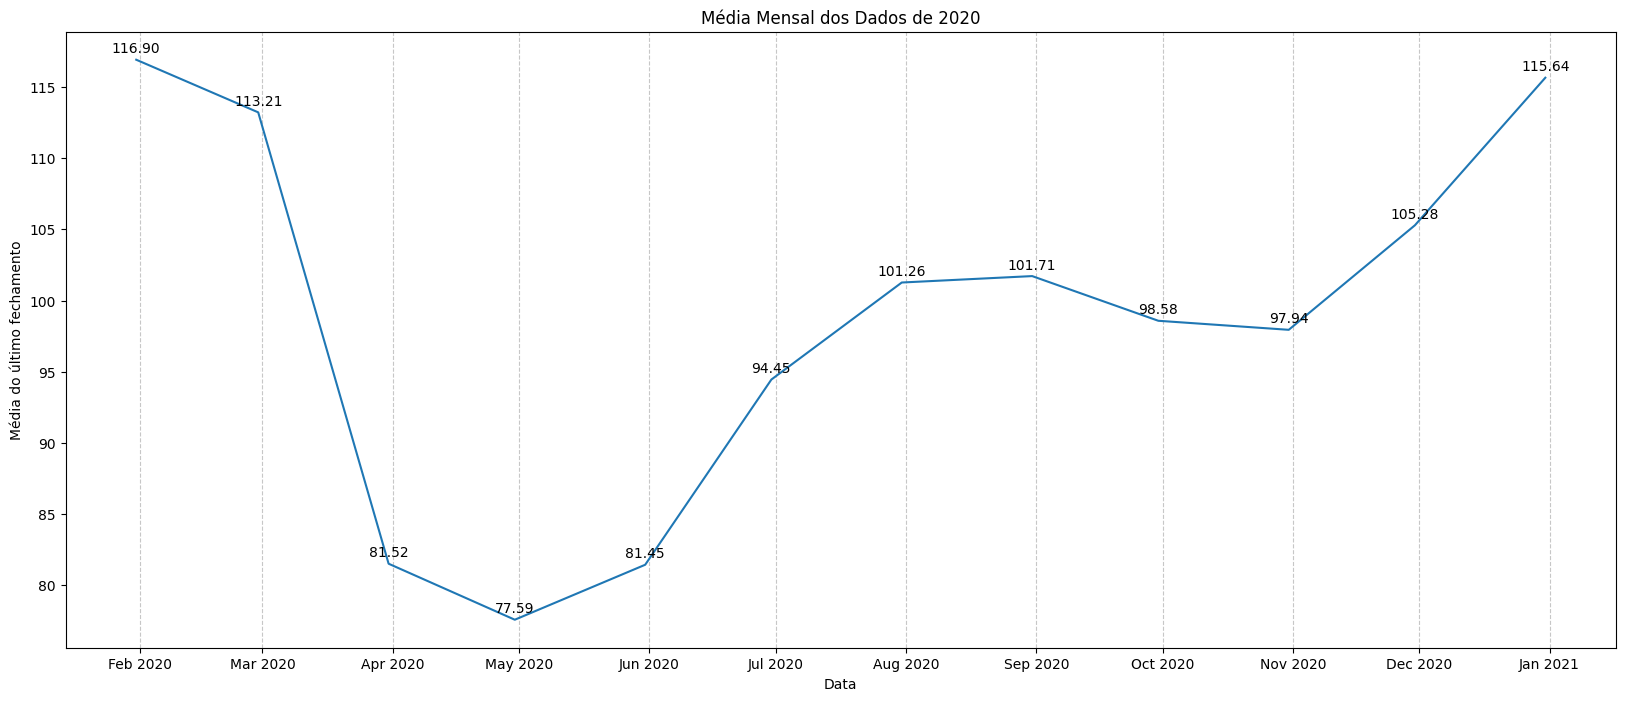

In [ ]:
# Criar um novo DataFrame contendo apenas os dados de 2020 para analisar um pouco melhor a queda na época da pandemia, foi o periodo que mais tivemos oscilação da bolsa de valores.
df_2020 = df[df.index.year == 2020]

# Resample para média mensal
df_2020_resampled_monthly = df_2020.resample('M').mean()

# Plotar os dados mensais de 2020 com mais ticks no eixo x e linhas de grade
plt.figure(figsize=(20, 8))
plt.plot(df_2020_resampled_monthly.index, df_2020_resampled_monthly['Último'])
plt.title('Média Mensal dos Dados de 2020')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_2020_resampled_monthly.index, df_2020_resampled_monthly['Último']):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

# **Decompondo a série temporal**

Agora vamos entender um pouco da **Tendência**, **Sazonalidade**, **Ruído** e se a série é **aditiva** ou **multiplicativa**.

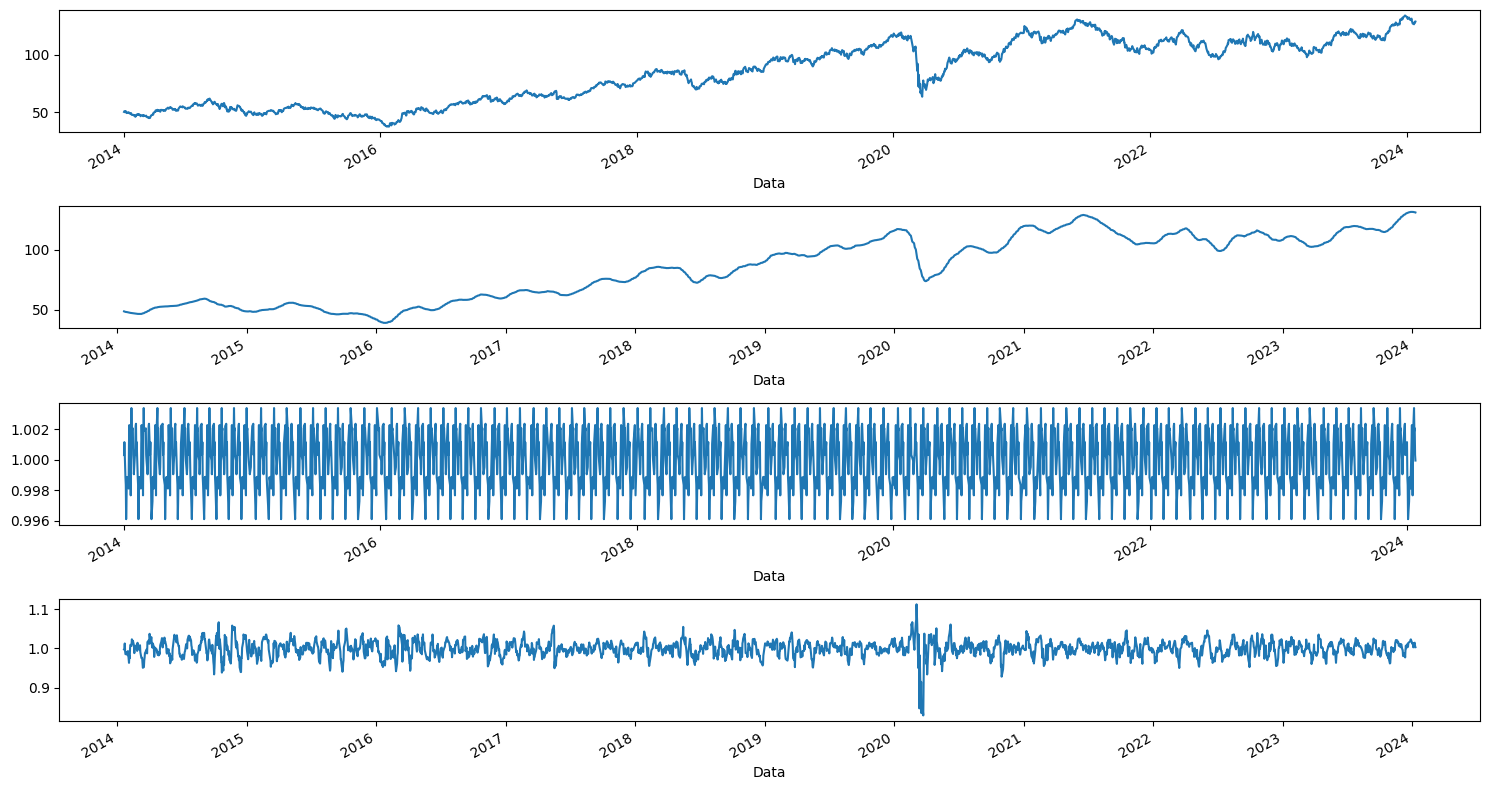

In [ ]:
df_limpo = df # cópia do dataframe
df_limpo = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']) # Removendo colunas desnecessárias

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=25)  #decopondo a série temporal, colocamos period=25, depois de fazer alguns testes, essa quantidade pareceu mostrar a realidade dos dados.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

Observando os gráficos acima podemos notar que a série possui uma leve tendência de alta no decorrer dos anos, mesmo com as grandes oscilações. Além disso, não fica muito claro os periodos de sazonalidade, indicando que há variação, mas que não ocorrem com algum padrão e acabamos encontrando muitos residuos, principalmente em 2020 quando houve a pandemia.

Assim podemos ter certeza que a série é Multiplicativa e possui muita variação ao longo do tempo

# **Entendendo um pouco o cenário brasileiro para complementar a análise dos dados**

A economia Brasileira vem crescendo gradativamente ao longa da última década, com cada vez mais empresas abrindo capital e vendendo ações na bolsa de valores, além da educação financeira e acessibilidade de investimento estarem cada vez mais disponíveis para os brasileiros, por isso a tendência da IBOVESPA (Bolsa de Valores de São Paulo) está de alta, pois cada vez mais pessoas tem acesso a esse produto e cada vez mais opções de investimentos aparecem na bolsa.

Também conseguimos entender que é normal a variação diária da bolsa, pois ela pode ser influenciada por diversos fatores, desde fatores da própria empresa como vendas, dividas e etc. Até fatores macroeconomicos como a taxa de juros, a cotação do dolar, o governo atual do pais e etc.

A gigantesca variação de 2020 foi por conta da pandemia, onde a incerteza mundial fez com que muitas pessoas vendessem as suas ações desesperadamente, resultados nas maiores quedas já registrada pela IBOVESPA, porém após as grandes quedas vieram as "oportunidades", pois grandes empresas ficaram com as ações muito baratas, fazendo com que alguns investidores aproveitassem e voltassem a comprar essas ações novamente, resultado em grandes altas.

Esse cenário durou praticamente o ano de 2020 inteiro, é onde conseguimos ver as maiores variações na nossa série.

# **Testando alguns modelos**

Agora que já endendemos o comportamento dos nossos dados, vamos partir para o teste de alguns modelos para identificar quais performam melhor.

  # **Média Móvel**

In [ ]:
# Criando uma média móvel com base nos últimos 10 e 20 dias.
df_limpo['MA_window_10'] = df_limpo['Último'].rolling(10).mean().shift() #média móvel em 10 dias
df_limpo['MA_window_20'] = df_limpo['Último'].rolling(20).mean().shift() #média móvel em 20 dias

In [ ]:
df_limpo.head(30)

,Último,MA_window_10,MA_window_20
Data,,,
2024-01-26,128.967,NaN,NaN
2024-01-25,128.169,NaN,NaN
2024-01-24,127.816,NaN,NaN
2024-01-23,128.263,NaN,NaN
2024-01-22,126.602,NaN,NaN
2024-01-19,127.636,NaN,NaN
2024-01-18,127.316,NaN,NaN
2024-01-17,128.524,NaN,NaN
2024-01-16,129.294,NaN,NaN


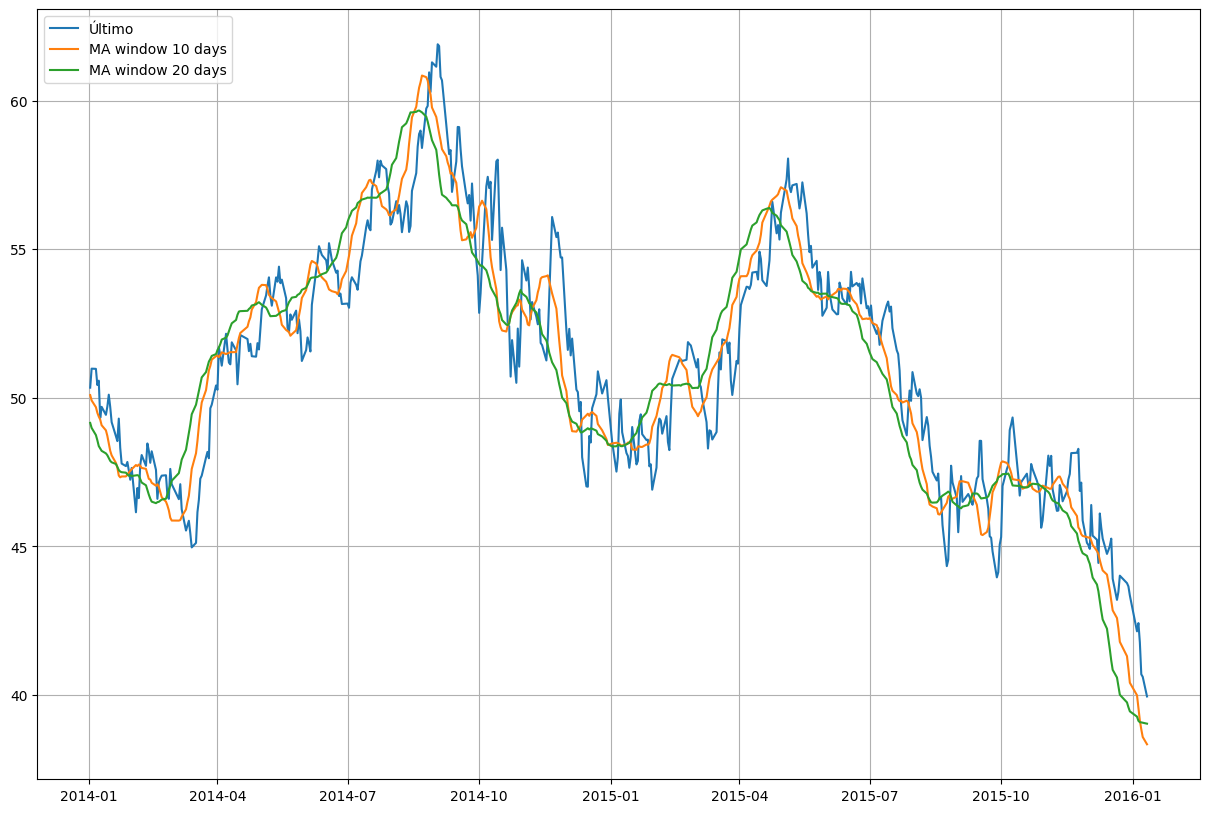

In [ ]:
# Plotando os resultados da nossa série e da média móvel podemos notar que até acertamos a têndencia, mas não conseguimos prever com exatidão o valor real.

limit = 500

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_limpo['Último'][-limit:], label='Último')
plt.plot(df_limpo['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df_limpo['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

Levando em consideração que a nossa série é muito volátil e que já conseguimos notar que não acetamos com exatidão a previsão com as médias de 10 e 20 dias, não vamos seguir com o treinamento deste modelo.

Como a idéia é prever os próximos dias e meses, com esse método e o passar do tempo, teriamos resultados desconéxos da realidade, por utiliziar simplesmente a média dos últimos dias.

  # **Arima**

In [ ]:
# limpando novamente o df para o novo modelo
df_limpo = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'])
df_limpo.head()

,Último
Data,
2024-01-26,128.967
2024-01-25,128.169
2024-01-24,127.816
2024-01-23,128.263
2024-01-22,126.602


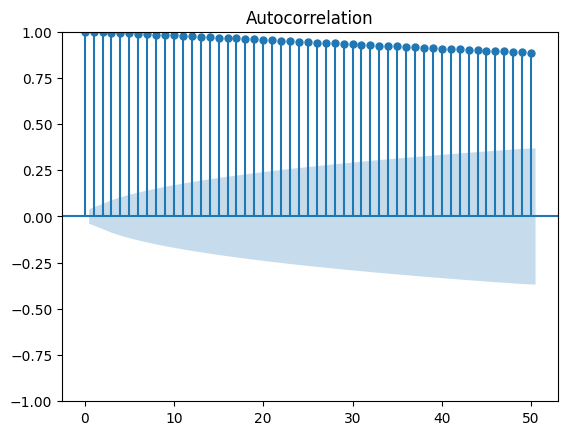

In [ ]:
# verificando o gráfico de auto correlação ACF, podemos notar que existe uma correlação com os dados, seja indireta ou direta.
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

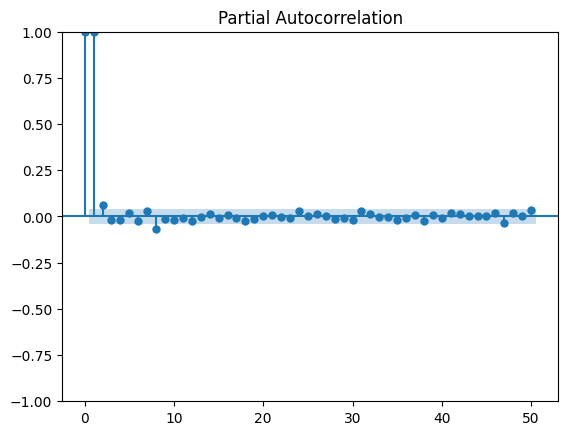

In [ ]:
# já utilizando o PACF para a correlação direta, podemos notar que não existe uma correlação.
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

In [ ]:
#Criando dois novos df para verificar a média móvel e o desvio padrão dos dados.

rolmean = df_limpo.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_limpo.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

               Último
Data                 
2024-01-26        NaN
2024-01-25        NaN
2024-01-24        NaN
2024-01-23        NaN
2024-01-22        NaN
...               ...
2014-01-08  49.381583
2014-01-07  49.557333
2014-01-06  49.696833
2014-01-03  49.900083
2014-01-02  50.036167

[2495 rows x 1 columns]               Último
Data                
2024-01-26       NaN
2024-01-25       NaN
2024-01-24       NaN
2024-01-23       NaN
2024-01-22       NaN
...              ...
2014-01-08  0.645891
2014-01-07  0.617371
2014-01-06  0.732357
2014-01-03  0.721081
2014-01-02  0.623090

[2495 rows x 1 columns]


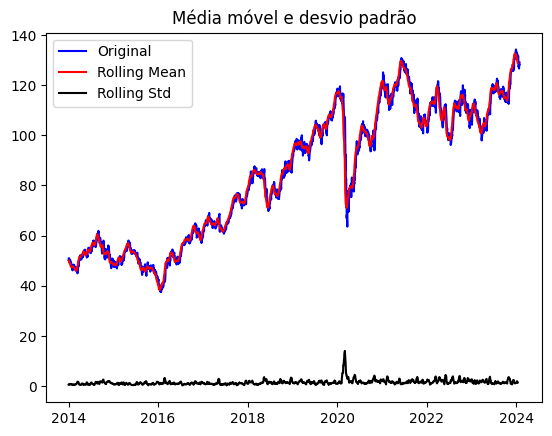

In [ ]:
#Plotando a média móvel e o desvio padrão podemos perceber que a serie não é estácionária, pois a média móvel está muito distante do desvio padrão.
orig = plt.plot(df_limpo, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

In [ ]:
# utilizando o Teste de Dickey-Fuller podemos comprovar estatisticamente que a série não é estácionária, pois os valores críticos estão abaixo das ADF Statistic e o valor de p não é abaixo de 0.05
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_limpo['Último'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.452025468638476
p-value: 0.5570962671914752
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -1.452025468638476
Valor-p: 0.5570962671914752
Valores Críticos:
   1%: -3.4329821119179256
   5%: -2.862702850392563
   10%: -2.5673890307492004


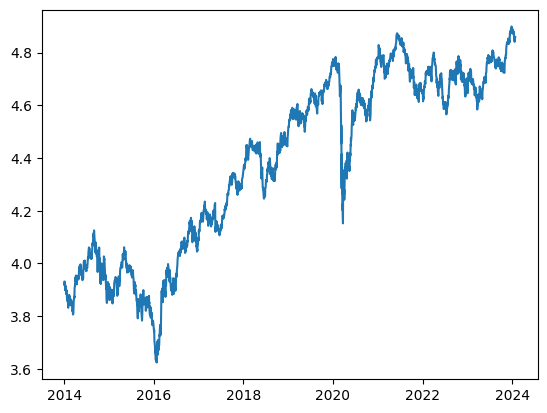

In [ ]:
#Utilizando o logaritmo, vamos realizar a transformação dos dados para tentar deixar a série como estacionária.
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma
plt.plot(indexedDataset_logScale)

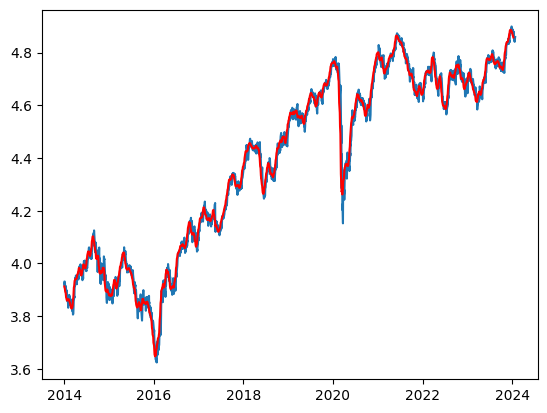

In [ ]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [ ]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Último
Data,
2024-01-11,0.014686
2024-01-10,0.014952
2024-01-09,0.017469
2024-01-08,0.021943
2024-01-05,0.016480
2024-01-04,0.007436
2024-01-03,0.016288
2024-01-02,0.011807
2023-12-28,0.019366


In [ ]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Último'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


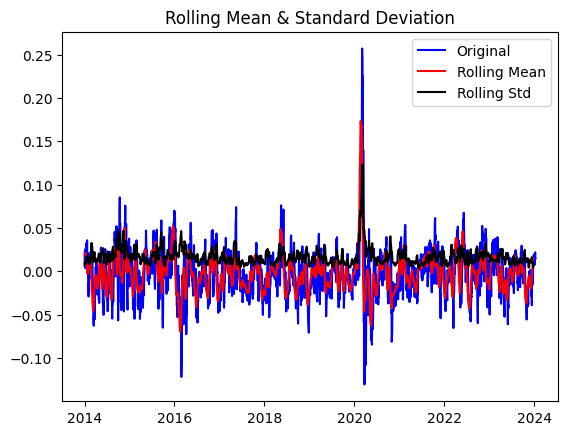

Results of Dickey Fuller Test:
Test Statistic                -1.283238e+01
p-value                        5.836509e-24
#Lags Used                     7.000000e+00
Number of Observations Used    2.476000e+03
Critical Value (1%)           -3.432994e+00
Critical Value (5%)           -2.862708e+00
Critical Value (10%)          -2.567392e+00
dtype: float64


In [ ]:
# Aqui podemos notar que a série ficou estácionária, pois o p valor ficou bem menor do que 0.05, sendo igual a 0.000000000000000000000005836509.
test_stationarity(datasetLogScaleMinusMovingAverage)

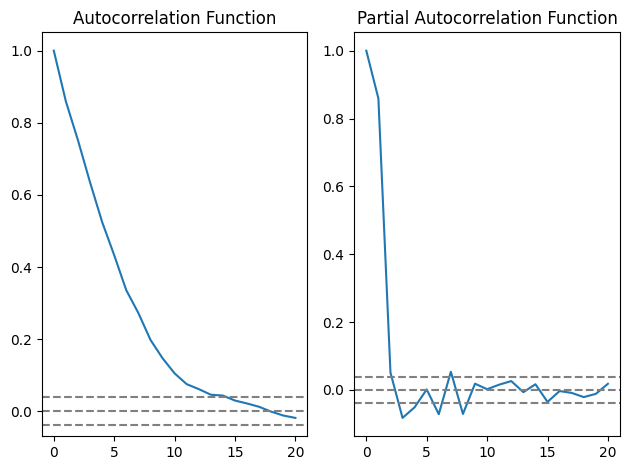

In [ ]:
# encontrando os valores de P e Q para os hiperparametros do Arima, analisando os gráficos podemos notar que Q = 18, P = 2 e como só fizemos uma transformação na série o I = 1

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogScaleMinusMovingAverage, nlags=20)
lag_pacf = pacf(datasetLogScaleMinusMovingAverage, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Plotting AR model


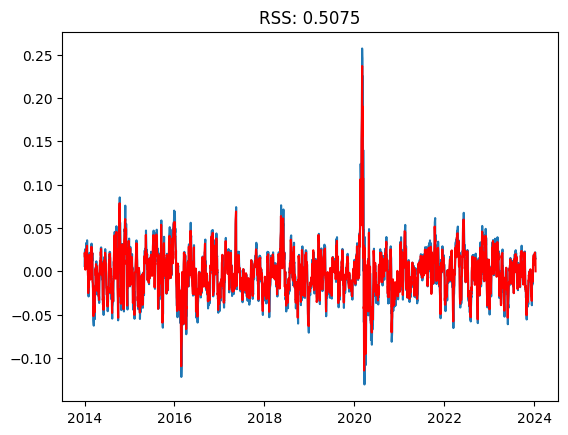

In [ ]:
#Configurando o arima e verificando a soma dos quadrados residuos

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(datasetLogScaleMinusMovingAverage, order=(2,1,18))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogScaleMinusMovingAverage)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogScaleMinusMovingAverage['Último'])**2))
print('Plotting AR model')

In [ ]:
# Calculando o MAPE do resultado do arima, como podemos notar o MAPE foi muito alto, sendo assim, o modelo não performou bem.

from sklearn.metrics import mean_absolute_error

predictions = results_AR.fittedvalues
predictions.index = datasetLogScaleMinusMovingAverage.index
predicted_values = indexedDataset_logScale['Último'].iloc[0] + np.cumsum(predictions)

mape = mean_absolute_error(datasetLogScaleMinusMovingAverage['Último'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 240.19%


  # **Prophet**

In [ ]:
#recriando o df do zero para evitar dados manipulados e já criando as colunas padrões do Prophet: ds e y
df = pd.read_csv("/content/Dados Históricos - Ibovespa.csv", sep = ",")
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'])
df[['ds', 'y']] = df[['Data', 'Último']]
df.head()

,Data,Último,ds,y
0,2024-01-26,128.967,2024-01-26,128.967
1,2024-01-25,128.169,2024-01-25,128.169
2,2024-01-24,127.816,2024-01-24,127.816
3,2024-01-23,128.263,2024-01-23,128.263
4,2024-01-22,126.602,2024-01-22,126.602


In [ ]:
#Separando os dados entre treino e teste para treinar o modelo
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1996, 4)
testing data size : (499, 4)


In [ ]:
# treinando o modelo

from prophet import Prophet

modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmphd23ykrj/tlr1n7g4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphd23ykrj/ya189s3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58023', 'data', 'file=/tmp/tmphd23ykrj/tlr1n7g4.json', 'init=/tmp/tmphd23ykrj/ya189s3_.json', 'output', 'file=/tmp/tmphd23ykrj/prophet_model7hq50qhu/prophet_model-20240129011227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:12:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:12:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-02,49.613535,42.613282,57.725695,49.613535,49.613535,0.577475,0.577475,0.577475,-1.012515,...,0.054956,0.054956,0.054956,1.535035,1.535035,1.535035,0.0,0.0,0.0,50.191010
1,2014-01-03,49.641708,42.374735,57.248622,49.641708,49.641708,0.467906,0.467906,0.467906,-1.012515,...,-0.207825,-0.207825,-0.207825,1.688246,1.688246,1.688246,0.0,0.0,0.0,50.109614
2,2014-01-06,49.726227,43.639923,58.445964,49.726227,49.726227,1.043887,1.043887,1.043887,-1.012515,...,-0.075790,-0.075790,-0.075790,2.132192,2.132192,2.132192,0.0,0.0,0.0,50.770114
3,2014-01-08,49.782573,43.883280,58.559730,49.782573,49.782573,1.464001,1.464001,1.464001,-1.012515,...,0.082680,0.082680,0.082680,2.393836,2.393836,2.393836,0.0,0.0,0.0,51.246574
4,2014-01-09,49.810746,43.538732,59.569998,49.810746,49.810746,1.551408,1.551408,1.551408,-1.012515,...,0.054956,0.054956,0.054956,2.508968,2.508968,2.508968,0.0,0.0,0.0,51.362154


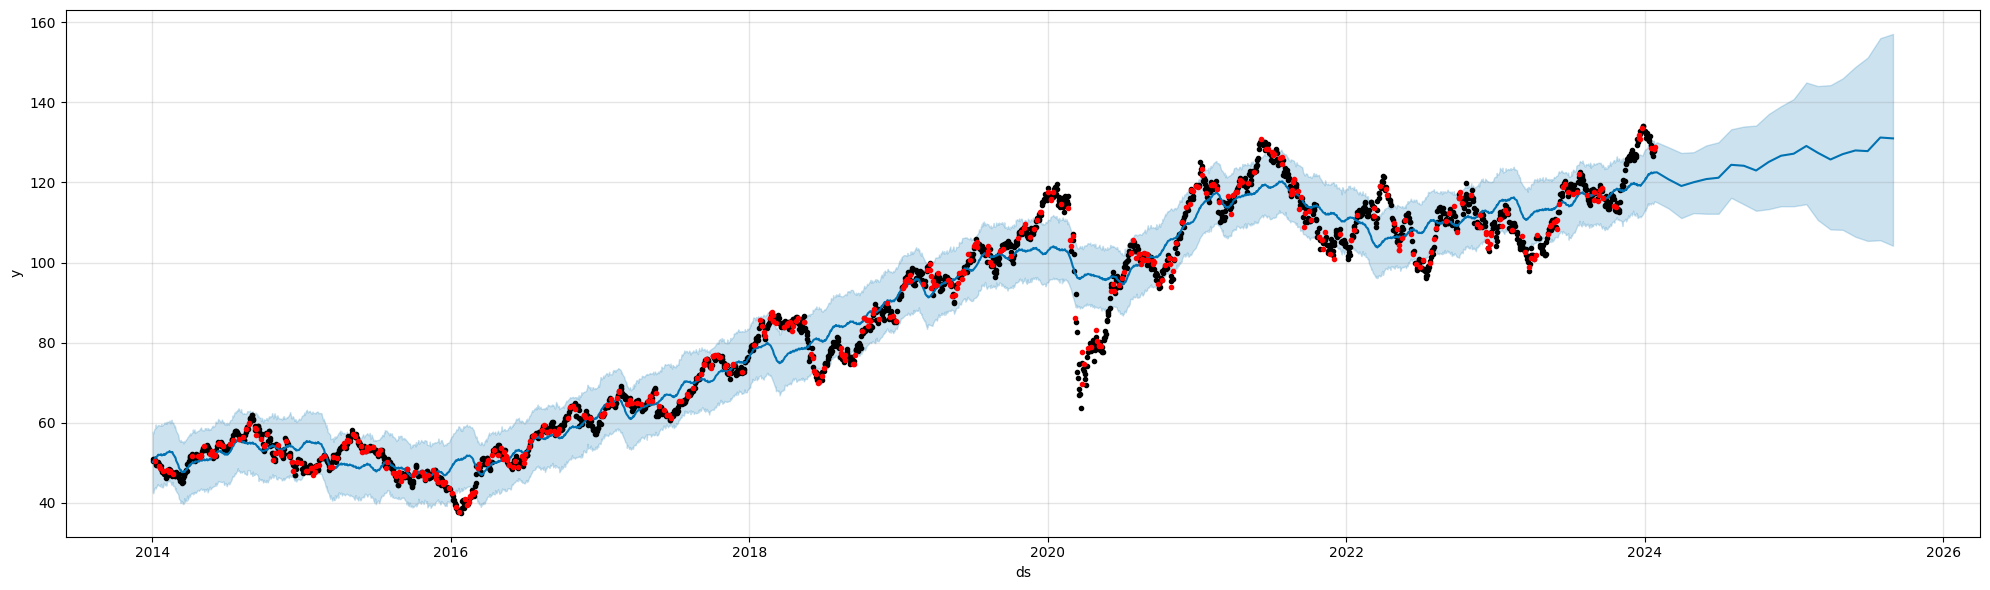

In [ ]:
#Analisando os resultados do modelo no plot abaixo, podemos notar que os pontos pretos que são os reais estão muito próximos dos pontos vermelhos que são os gerados pelo modelo, ou seja, o modelo ficou bom.

modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [ ]:
# Calculando o MAP e o RMSE, podemos notar que o modelo performou bem, mas ainda não é o esperado.
# Imaginamos que a pandemia pode estar influenciando negativamente no modelo, dado que foi onde ele mais errou e tivemos os maiores desvios.
# Abaixo vamos realizar o mesmo treinamento do modelo, porém com dados a partir de 2021, para minimizar os problemas da pandemia.

from sklearn.metrics import mean_squared_error

previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

mape = np.mean(resultados['erro_percentual_absoluto'])


# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(test_data['y'], previsao.loc[:len(test_data)-1, 'yhat']))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

RMSE: 41.165960312223234
MAPE: 5.43%


In [ ]:
#recriando o df do zero, agora com dados a partir de 01/01/2021 para retirar o impacto da pandemia dos dados.
df = pd.read_csv("/content/Dados Históricos - Ibovespa_sem_pandemia.csv", sep = ",")
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'])
df[['ds', 'y']] = df[['Data', 'Último']]
df.head()

,Data,Último,ds,y
0,2024-01-26,128.967,2024-01-26,128.967
1,2024-01-25,128.169,2024-01-25,128.169
2,2024-01-24,127.816,2024-01-24,127.816
3,2024-01-23,128.263,2024-01-23,128.263
4,2024-01-22,126.602,2024-01-22,126.602


In [ ]:
#Separando os dados entre treino e teste para treinar o modelo
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (611, 4)
testing data size : (153, 4)


In [ ]:
# Criando um df contendo os dias no brasil que não possui fechamento de bolsa (dias não úteis), para posteriormente excluir essas datas da predição.

#pip install workalendar

import pandas as pd
from workalendar.america import Brazil

# Instanciando o calendário brasileiro
calendario_brasileiro = Brazil()

# Obtendo os feriados brasileiros de 2024
feriados_2024 = calendario_brasileiro.holidays(2024)

# Convertendo as datas dos feriados para o formato DataFrame
df_feriados = pd.DataFrame(feriados_2024, columns=['Data', 'Feriado'])

# Criando um DataFrame com todas as datas de 2024
datas_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')

# Filtrando os dias não úteis (feriados e finais de semana)
dias_nao_uteis = datas_2024[(~datas_2024.isin(df_feriados['Data'])) & (datas_2024.weekday >= 5)]

# Criando um DataFrame com as datas de dias não úteis
df_dias_nao_uteis = pd.DataFrame({'Data': dias_nao_uteis, 'Dia útil': False})

# Juntando os DataFrames de feriados e dias não úteis
df_dias_nao_uteis = pd.concat([df_feriados, df_dias_nao_uteis]).sort_values(by='Data').reset_index(drop=True)

# Exibindo o DataFrame final
print(df_dias_nao_uteis)


                    Data        Feriado Dia útil
0             2024-01-01       New year      NaN
1    2024-01-06 00:00:00            NaN    False
2    2024-01-07 00:00:00            NaN    False
3    2024-01-13 00:00:00            NaN    False
4    2024-01-14 00:00:00            NaN    False
..                   ...            ...      ...
103  2024-12-21 00:00:00            NaN    False
104  2024-12-22 00:00:00            NaN    False
105           2024-12-25  Christmas Day      NaN
106  2024-12-28 00:00:00            NaN    False
107  2024-12-29 00:00:00            NaN    False

[108 rows x 3 columns]


<ipython-input-776-9c8e4e2c1146>:27: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_dias_nao_uteis = pd.concat([df_feriados, df_dias_nao_uteis]).sort_values(by='Data').reset_index(drop=True)


In [ ]:
# treinando o modelo já retirando dias não úteis

from prophet import Prophet

modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=150, freq='D')
dataFramefuture = dataFramefuture[~dataFramefuture['ds'].isin(df_dias_nao_uteis['Data'])]
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmphd23ykrj/9im44akm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphd23ykrj/shar2u4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98213', 'data', 'file=/tmp/tmphd23ykrj/9im44akm.json', 'init=/tmp/tmphd23ykrj/shar2u4c.json', 'output', 'file=/tmp/tmphd23ykrj/prophet_modelrobsolr_/prophet_model-20240129014309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,117.956526,114.420845,121.875194,117.956526,117.956526,0.193692,0.193692,0.193692,1.934814,...,0.026242,0.026242,0.026242,-1.767365,-1.767365,-1.767365,0.0,0.0,0.0,118.150218
1,2021-01-05,117.926725,114.589687,121.687783,117.926725,117.926725,0.281939,0.281939,0.281939,1.934814,...,0.124769,0.124769,0.124769,-1.777645,-1.777645,-1.777645,0.0,0.0,0.0,118.208664
2,2021-01-06,117.896925,114.541609,121.774448,117.896925,117.896925,0.215981,0.215981,0.215981,1.934814,...,0.071129,0.071129,0.071129,-1.789962,-1.789962,-1.789962,0.0,0.0,0.0,118.112905
3,2021-01-07,117.867124,114.568200,121.738864,117.867124,117.867124,0.325081,0.325081,0.325081,1.934814,...,0.192694,0.192694,0.192694,-1.802428,-1.802428,-1.802428,0.0,0.0,0.0,118.192205
4,2021-01-08,117.837323,114.421096,121.514731,117.837323,117.837323,0.190553,0.190553,0.190553,1.934814,...,0.068870,0.068870,0.068870,-1.813131,-1.813131,-1.813131,0.0,0.0,0.0,118.027876


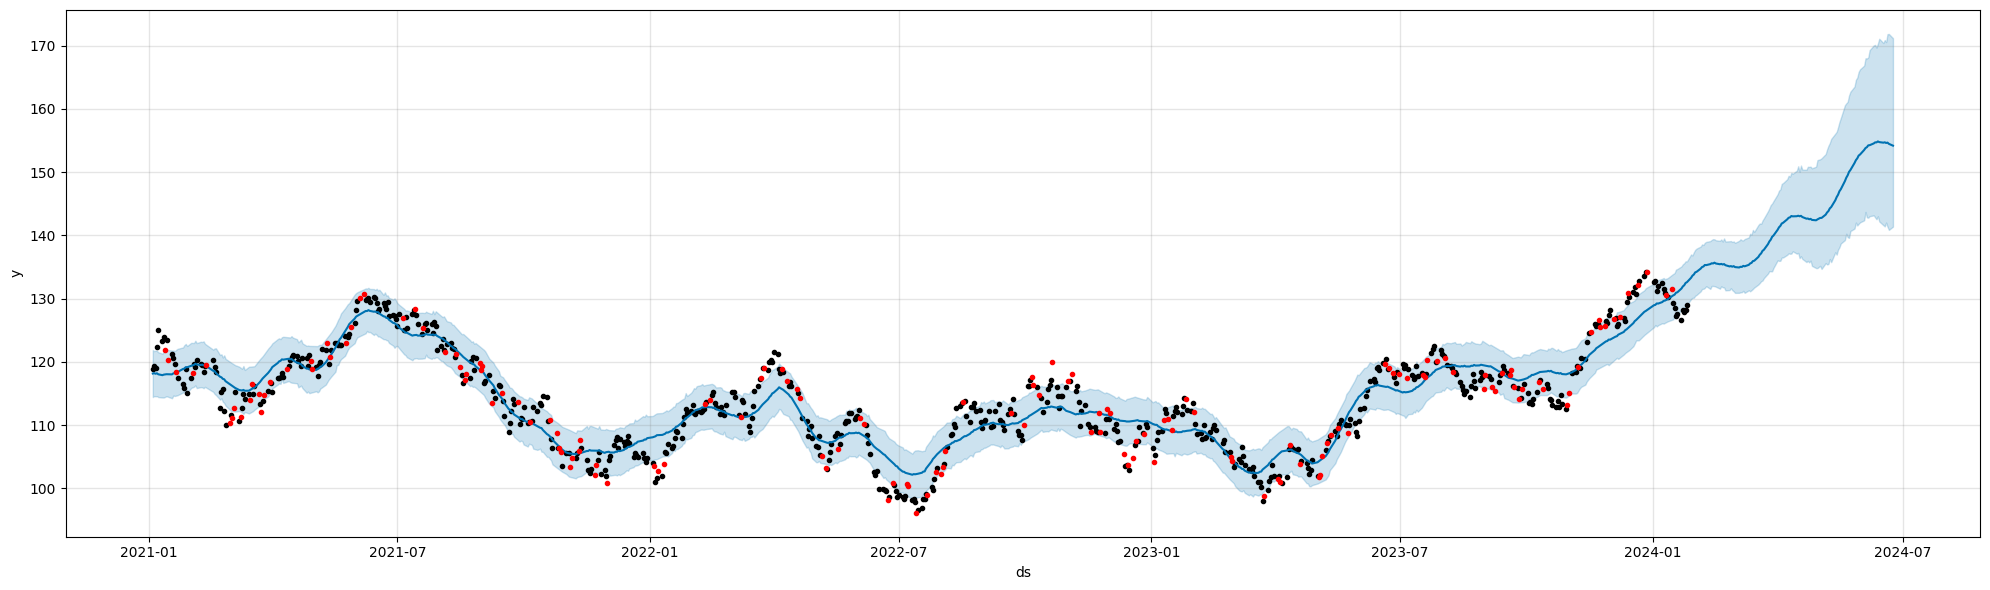

In [ ]:
#Analisando os resultados do modelo no plot abaixo, podemos notar que os pontos pretos que são os reais estão muito próximos dos pontos vermelhos que são os gerados pelo modelo, ou seja, o modelo ficou bom.

modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [ ]:
# Calculando o MAP e o RMSE, podemos notar que o modelo performou MUITO melhor sem o impacto dos dados da pandemia, e agora estamos satisfeitos :)

from sklearn.metrics import mean_squared_error

previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

mape = np.mean(resultados['erro_percentual_absoluto'])


# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(resultados['y'], previsao.loc[:len(resultados)-1, 'yhat']))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

RMSE: 2.7855352149151775
MAPE: 1.99%


# **Considerações finais**

Após toda a análise dos dados e o teste de 3 modelos diferentes, podemos dizer que o modelo que obtivemos uma melhor performance foi o prophet e além disso, podemos notar que neste modelo, os dados da pandemia estavam mais atrapalhando do que ajudando, pois foi algo muito incomum que aconteceu e inferir isso no futuro acabava gerando mais erros.

Sendo assim ficamos com o prophet e dados a partir de 01/01/2021 como o nosso modelo final : )